# predicting health coverage in the US

This project will call data from the American Community Survey Public Use MicroSample(PUMS) API. The most recent survey publicly availble at this API is from 2019. (Note data from 2020 are available to download in csv files).

This project uses the Census Bureau Data API but is not endorsed or certified by the Census Bureau.

1. American Community Survey (ACS) (census.gov).
https://www.census.gov/programs-surveys/acs/
2. American Community Survey Data via API (census.gov).
https://www.census.gov/programs-surveys/acs/data/data-via-api.html

The goal of this project is to predict whether an individual has health insurance (or not) based on demographic data in the PUMS. 

In [1]:
# import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
import numpy as np
from dotenv import load_dotenv
import utils

Load the cleaned data from csv file and the code dictionary for the column names.

In [2]:
datadir = os.path.join(os.getcwd(),"raw_data")
interimdatadir = os.path.join(os.getcwd(),"interim_data")
figdir = os.path.join(os.getcwd(),"plots")

In [3]:
_,_,_,nsamples = utils.getVars()
fname    = os.path.join(interimdatadir,'allstates_subsample' + str(nsamples) + '.csv')
df       = pd.read_csv(fname,low_memory=False)
fname = os.path.join(interimdatadir,str(nsamples) + 'targets_oi.csv')
targ_oi  = pd.read_csv(fname)
codedict,code = utils.getCodeDictionary()
target   = targ_oi['healthcodes'][1]
df

,Unnamed: 0,index,HHLANP,FBATHP,DRIVESP,FWATP,FBROADBNDP,FWKWNP,HOTWAT,FWKHP,...,SOCP,FSMOCP,FDOUTP,PERNP,SCH,WKL,TEL,TEN,BST,STATE
0,0,24495,9500,0,0,0,0,0,9,0,...,472031,0,0,1200,1,1,1,3,1,AL
1,1,18440,9500,0,1,0,0,0,9,0,...,1910XX,0,0,40700,1,1,1,1,1,AL
2,2,24661,9500,0,0,0,0,0,9,0,...,-1,0,0,-10001,2,0,1,1,1,AL
3,3,21273,9500,0,0,0,0,0,9,0,...,-1,0,0,0,1,3,1,3,1,AL
4,4,12532,9500,1,0,1,0,0,9,0,...,533030,1,1,0,1,2,1,1,1,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,10195,4765,9500,0,0,0,0,0,9,0,...,-1,0,0,0,1,3,1,1,56,WY
10196,10196,2936,9500,0,0,0,0,0,9,0,...,-1,0,0,0,1,3,1,3,56,WY
10197,10197,4673,9500,0,1,0,0,0,9,0,...,395094,1,0,45000,1,1,1,1,56,WY
10198,10198,4121,9500,0,2,1,0,1,9,0,...,352010,0,0,12700,2,1,1,3,56,WY


In [4]:
df.drop('Unnamed: 0',axis=1,inplace=True)

We know that there are a number of categorical variables in the dataset, as well as numerical variables. We can use the predictive power score (pps) to estimate the predictive power of each variable for our target variable. However, to use the predictive power score, we need to convert categorical variables to data type 'category.' 

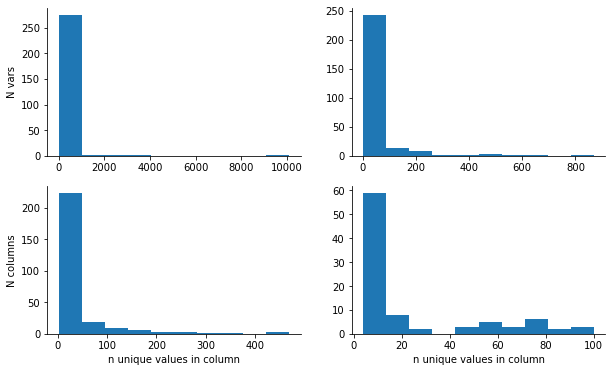

In [5]:
#try to identify categorical variables by considering number of unique values?
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
plt.hist(df.nunique()) 
plt.ylabel('N vars')
plt.title('')
sns.despine()

plt.subplot(2,2,2)
plt.hist(df.nunique()[df.nunique().between(1,1500)])
sns.despine()

plt.subplot(2,2,3)
plt.hist(df.nunique()[df.nunique().between(1,500)])
sns.despine()
plt.xlabel('n unique values in column')
plt.ylabel('N columns')

plt.subplot(2,2,4)
plt.hist(df.nunique()[df.nunique().between(4,100)])
sns.despine()
plt.xlabel('n unique values in column')
plt.show()

Spot check info available for a variable that is very likely categorical (<=3 unique values)

In [6]:
cols = df.columns[df.nunique().between(2,3)]
dets = utils.variableDetails(cols[0])
print(dets['label'])
print('values:')
print(dets['values']['item'])

Bathtub or shower allocation flag
values:
{'1': 'Yes', '0': 'No', '-1': 'N/A (GQ)'}


Spot check info available for a variable that is very likely numerical (> 500 unique values)

In [7]:
cols = df.columns[df.nunique().gt(800)]
dets = utils.variableDetails(cols[1])
print(dets['label'])
print('values:')
print(dets['values']['item'])

Total person's income (signed, use ADJINC to adjust to constant dollars)
values:
{'-19999': 'N/A (less than 15 years old)', '-19998': 'Loss of $19998 or more (Rounded and bottom-coded components)', '0': 'None'}


We know that the index column comes from the index in the row from our api call. It is categorical and at this point we do not need it, so we can drop. 

In [8]:
df.drop('index',axis=1,inplace=True)

It looks like info on numerical values (like in the immediate cell above) includes a 'range' key to indicate the min and max of that numerical variable, while categorical variables do not include that information. Maybe we can use this to identify categorical/numerical variables. 

Call API for states in loop and save csv locally if it doesn't exist yet

In [9]:
column_list = df.columns.tolist()
column_list.remove('STATE')
fname = os.path.join(interimdatadir,'datatype_ncol' + str(df.shape[1]) + '.csv')
if os.path.exists(fname) == False:  
    range_key = list()
    info_from_api = list()
    n_unq_vals = list()
    for column in column_list:
        try: 
            dets = utils.variableDetails(column)
            range_key.append('range' in dets['values'].keys())
            info_from_api.append(True)
            n_unq_vals.append(df[column].nunique())
        except:
            range_key.append(False)
            info_from_api.append(False)
            n_unq_vals.append(df[column].nunique())
    datatype = pd.DataFrame({'var_name':column_list,'range_key':range_key,'n_unq_vals':n_unq_vals,'info_from_api':info_from_api})
    datatype.to_csv(fname)
else:
    datatype = pd.read_csv(fname)

In [10]:
print('The number of columns in our main df should equal the number of rows in our datatype dataframe: ')
print('df column N:' + str(datatype.shape[1]))
print('datatype rows N:' + str(datatype.shape[0]))
print('The only vars where numerical info is not from the api:')
print(datatype[datatype.info_from_api == False]['var_name'])

The number of columns in our main df should equal the number of rows in our datatype dataframe: 
df column N:4
datatype rows N:279
The only vars where numerical info is not from the api:
159          ST
178    SERIALNO
278         BST
Name: var_name, dtype: object


We can do another check to see if this approach is adding up. Are there any variables coming out as categorical that have a very high number of unique values? Are any coming out as numerical that have very few unique values? 

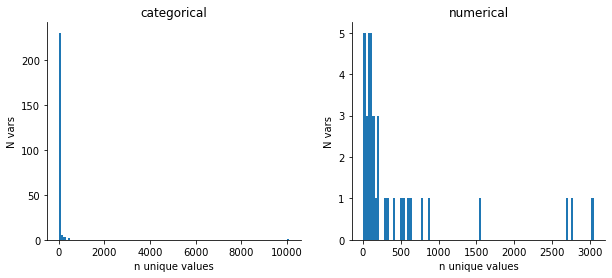

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(datatype['n_unq_vals'].loc[datatype['range_key']==False],bins=100) 

plt.ylabel('N vars')
plt.xlabel('n unique values')
plt.title('categorical')
sns.despine()

plt.subplot(1,2,2)
plt.hist(datatype['n_unq_vals'].loc[datatype['range_key']==True],bins=100) 
plt.xlabel('n unique values')
plt.ylabel('N vars')

plt.title('numerical')
sns.despine()

plt.show()

We can check our vars that lie on the unexpected extremes (low unique N, numerical)

In [12]:
min_cat_row = datatype.iloc[datatype['n_unq_vals'].loc[datatype['range_key']==True].idxmin()]
min_cat_row

var_name         RACNUM
range_key          True
n_unq_vals            5
info_from_api      True
Name: 87, dtype: object

In [13]:
print('var with min number of unique values that may be numerical:') 
min_cat_row = datatype.iloc[datatype['n_unq_vals'].loc[datatype['range_key']==True].idxmin()]

dets = utils.variableDetails(min_cat_row['var_name'])
print(dets)

var with min number of unique values that may be numerical:
{'name': 'RACNUM', 'label': 'Number of major race groups represented', 'predicateType': 'int', 'group': 'N/A', 'limit': 0, 'suggested-weight': 'PWGTP', 'values': {'range': [{'min': '1', 'max': '6', 'description': 'Race groups'}]}}


This is numerical, so the approach may be working..

We can check our vars that lie on the unexpected extremes (high unique N, categorical)

In [14]:
print('var with max number of unique values that may be categorical:') 
max_cat_row = datatype.iloc[datatype['n_unq_vals'].loc[datatype['range_key']==False].idxmax()]

print(max_cat_row)

# get deets:
dets = utils.variableDetails(max_cat_row['var_name'])
print(dets)

var with max number of unique values that may be categorical:
var_name         SERIALNO
range_key           False
n_unq_vals          10114
info_from_api       False
Name: 178, dtype: object
{'name': 'SERIALNO', 'label': 'Housing unit/GQ person serial number', 'predicateType': 'int', 'group': 'N/A', 'limit': 0, 'suggested-weight': 'PWGTP'}


This one also checks out. Now we can convert the datatypes in the main df.

In [15]:
datatype.set_index('var_name',inplace=True)

In [16]:
print('converting data types...')
for index in datatype.index:
    if datatype.loc[index].range_key == False:
        df[index] = df[index].astype('category')

converting data types...


In [22]:
# save new data frames
new_df_fname = os.path.join(interimdatadir,'allstates_subsample' + str(nsamples) + '_defvars_df.pkl')
df.to_pickle(new_df_fname)